In [1]:
push!(LOAD_PATH, "..")
using ASE, Potentials, MatSciPy, AtomsInterface, TestAtoms, TightBinding
using PyPlot
import AtOptim
import AtPrecon

In [19]:
function ref_config(N)
    # reference configuration
    at = bulk("Al"; cubic=true)
    at = repeat(at, (N, N, N))
    # set_pbc(at, (true, true, true))
    r0 = rnn("Al")
    rcut = 2.5 * r0
    calc = MatSciPy.PairCalculator( SWCutoff( LennardJonesPotential(r0, 1.0), rcut, 1.0 ) )
    
    # remove one atom
    positions(at)
    X = positions(at);
    xvac = X[:,1]
    xneig = X[:,2]
    if abs( norm(xvac - xneig) - r0 ) > 1e-2
        error("the atom pair I found doesn't seem to be neighbours")
    end
    X1 = X[:,2:end]
    # this operation is identical to saying: (I HOPE!!!)
    delete_atom!(at, 1)
    
    # get another configuration where the neighbour
    # has moved into the vacancy site
    X2 = copy(X1)
    X2[:,1] = xvac
    
    # a good orientation will be X2 - X1
    V = X2 - X1
    # and a good starting point will (hopefully)
    # be some point between X1 and X2
    X = 0.33 * X2 + 0.66 * X1
    
    return at, calc, X, V
end


function run_test(N; precon=true, output=true, maxnit = 1000, h = 1e-2)
    println("================================")
    println("N = ", N, ", precon = ", precon)
    println("================================")
    at, calc, X, V = ref_config(N)

    # these parameters are hand-tuned for system size N = 3
    if precon
        alpha = 0.5
        beta = 0.01
        P = AtPrecon.ExpPrecon(at, calc)
    else
        alpha = 0.01
        beta = 0.005
        P = 1
    end

    # define an objective function
    obj(Y) = potential_energy_d(set_positions!(at, Y), calc)
    
    Res_x = Float64[]
    Res_v = Float64[]
    

    for n = 1:maxnit
        # update the preconditioner
        if P != 1
            AtPrecon.update!(P, set_positions!(at, X))
        end

        # normalise V
        V = V / sqrt( vecdot(V, V * P) )

        # compute the two gradients
        dEp = obj(X + h * V)
        dEm = obj(X - h * V)

        # compute the translation step
        # x ← x - α (I - 2 v ⊗ v) ∇E
        dEx = 0.5 * (dEp + dEm)
        res_x = norm(dEx[:], Inf)
        dEx_p = dEx / P
        X = X - alpha * (dEx_p - 2 * vecdot(V, dEx) * V)

        # compute the rotation step: unexpected version (?!?!?)
        # v ← v - β (Hv - λ Pv)  >>> - ∇_v <Hv,v>/<Pv,v>
        dEv = (dEp - dEm) / (2.0 * h)
        lambda = vecdot(dEv, V)
        Qv = dEv - lambda * (V * P)
        res_v = norm(Qv[:], Inf)
        V = V - beta * Qv

    #     # compute the rotation step: what it ought to be?!
    #     # v ← v - β (P^{-1} - v ⊗ v) (∇E⁺ - ∇E⁻) / 2h
    #     #    >>>> - P^{-1} ∇_v <Hv,v>/<Pv,v>
    #     dEv = (dEp - dEm) / (2.0 * h)
    #     lambda = vecdot(dEv, V)
    #     Qv = dEv - lambda * (V * P)
    #     res_v = norm(Qv[:], Inf)
    #     Qv_p = Qv / P
    #     V = V - beta * Qv_p

        # output
        if output
            @printf(" %4d |  %4.2e  |  %4.2e  |  %4.2e \n", n, res_x, res_v, lambda)
        end
        
        push!(Res_x, res_x)
        push!(Res_v, res_v)
    end
    
    return Res_x, Res_v
end


run_test (generic function with 5 methods)

In [20]:
# large
Res_x_P, _ = run_test(10; precon=true, output=true, maxnit = 80, h = 1e-2)
Res_x_I, _ = run_test(10; precon=false, output=true, maxnit = 80, h = 1e-2)
# small
Res_x_P_sm, _ = run_test(4; precon=true, output=true, maxnit = 80, h = 1e-2)
Res_x_I_sm, _ = run_test(4; precon=false, output=true, maxnit = 80, h = 1e-2)


    1 |  1.87e+01  |  4.99e+00  |  -1.81e-01 
    2 |  1.53e+01  |  6.45e+00  |  2.34e-01 
    3 |  2.35e+00  |  1.24e+00  |  1.93e-03 
    4 |  1.04e+00  |  7.33e-01  |  -1.52e-01 
    5 |  7.56e-01  |  3.82e-01  |  -2.24e-01 
    6 |  5.23e-01  |  2.02e-01  |  -2.55e-01 
    7 |  3.43e-01  |  1.13e-01  |  -2.63e-01 
    8 |  2.87e-01  |  7.72e-02  |  -2.65e-01 
    9 |  2.45e-01  |  5.54e-02  |  -2.64e-01 
   10 |  2.10e-01  |  4.35e-02  |  -2.63e-01 
   11 |  1.82e-01  |  3.51e-02  |  -2.61e-01 
   12 |  1.58e-01  |  2.93e-02  |  -2.60e-01 
   13 |  1.37e-01  |  2.48e-02  |  -2.59e-01 
   14 |  1.19e-01  |  2.14e-02  |  -2.59e-01 
   15 |  1.04e-01  |  1.91e-02  |  -2.58e-01 
   16 |  9.06e-02  |  1.70e-02  |  -2.58e-01 
   17 |  7.90e-02  |  1.52e-02  |  -2.57e-01 
   18 |  6.90e-02  |  1.35e-02  |  -2.57e-01 
   19 |  6.02e-02  |  1.21e-02  |  -2.57e-01 
   20 |  5.26e-02  |  1.08e-02  |  -2.57e-01 
   21 |  4.59e-02  |  9.63e-03  |  -2.56e-01 
   22 |  4.01e-02  |  8.60e-03  |  -

([18.7039,3.54003,2.44549,1.94313,1.61189,1.46773,1.40079,1.34273,1.29106,1.2441  …  0.0971438,0.0954197,0.0937321,0.0920802,0.0904634,0.0888809,0.0873321,0.0858162,0.0843325,0.0828804],[25.2131,12.1836,4.31367,2.07401,1.16375,0.717673,0.475154,0.336149,0.25492,0.208016  …  0.0534896,0.0519292,0.0509199,0.049899,0.0488707,0.0478386,0.046806,0.045776,0.0447512,0.0437341])

 80 |  8.29e-02  |  4.37e-02  |  -5.70e+00 


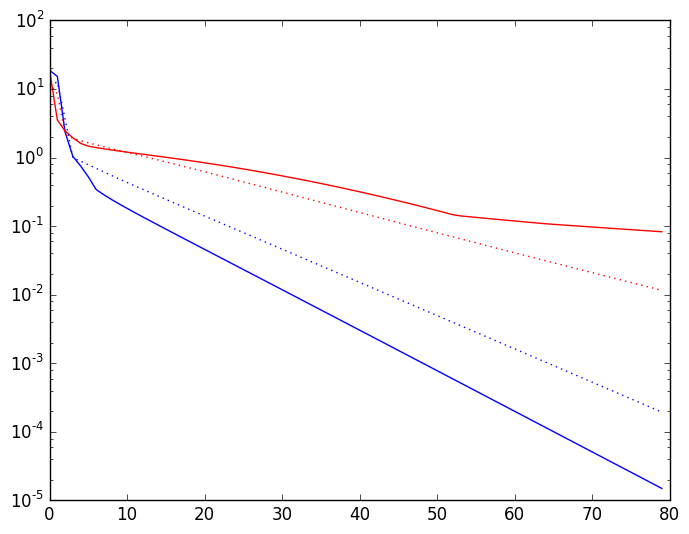

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31a21ddd0>

In [24]:
semilogy(Res_x_P, "b-")
semilogy(Res_x_I, "r-")
semilogy(Res_x_P_sm, "b:")
semilogy(Res_x_I_sm, "r:")